In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [17]:
# View all of the classes that automap found
print("Measurement")
for c in inspect(engine).get_columns('measurement'):
    print(f"{c['name']}: {c['type']}")
print("\nStation")
for c in inspect(engine).get_columns('station'):
    print(f"{c['name']}: {c['type']}")          

Measurement
id: INTEGER
station: TEXT
date: TEXT
prcp: FLOAT
tobs: FLOAT

Station
id: INTEGER
station: TEXT
name: TEXT
latitude: FLOAT
longitude: FLOAT
elevation: FLOAT


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
recdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recdate[0]

'2017-08-23'

<function matplotlib.pyplot.show(close=None, block=None)>

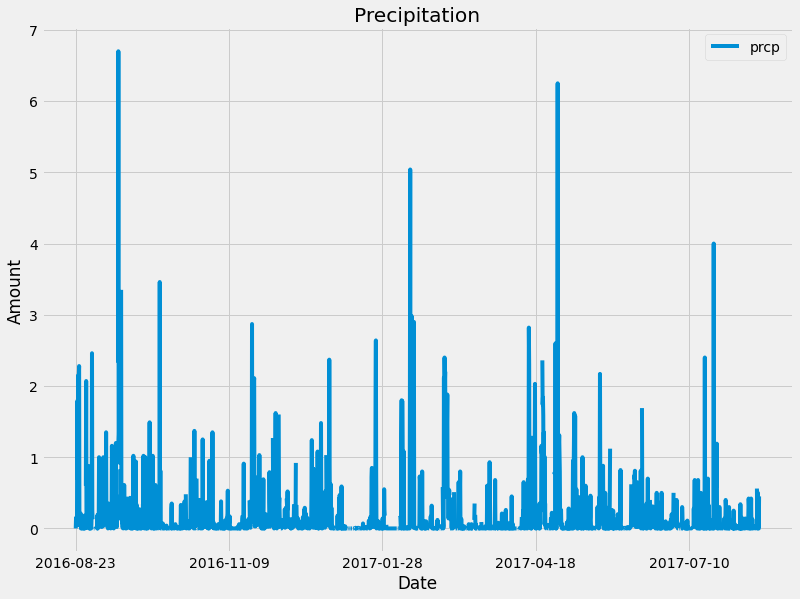

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.datetime.strptime(recdate[0], '%Y-%m-%d')
recyear = date.year
recmonth = date.month
recday = date.day

# Calculate the date one year from the last date in data set.
lastyear = recyear -1
lastdate = f"{lastyear}-{recmonth}-{recday}"

# Perform a query to retrieve the data and precipitation scores
data = (session
       .query(Measurement.date, Measurement.prcp)
        .filter(Measurement.date >= '2016-08-23')
        .order_by(Measurement.date)
        .all()
       )

# Save the query results as a Pandas DataFrame and set the index to the date column
dataframe = pd.DataFrame(data, columns=['date','prcp'])
dataframe = dataframe.set_index('date')

# Sort the dataframe by date
dataframe = dataframe.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
dataframe.plot(figsize=(12,9), title="Precipitation", xlabel="Date", ylabel="Amount")
plt.show

In [78]:
lastdate

'2016-8-23'

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dataframe.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number stations in the dataset
distinct_stations = session.query(Measurement.station).distinct().all()
all_stations = session.query(func.count(Measurement.station)).scalar()
print(f"There are {all_stations} station records in the data, with {len(distinct_stations)} unique stations present")

There are 19550 station records in the data, with 9 unique stations present


In [51]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
frequent = (session
            .query(Measurement.station, func.count(Measurement.station))
            .group_by(Measurement.station)
            .order_by(func.count(Measurement.station).desc())
            .all()
           )
most_frequent = frequent[0][0]
frequent

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
data = (session
       .query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
       .filter(Measurement.station == most_frequent)
        .all()
       )
data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

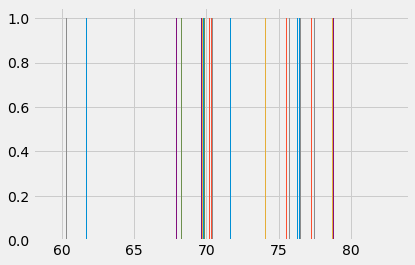

In [88]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = (session
       .query(Measurement.tobs)
        .filter(Measurement.date >= '2016-08-23')
       .filter(Measurement.station == most_frequent)
        .all()
       )

plt.hist(data, bins=12)
plt.figsize=(12,9)
plt.show()


# Close session

In [ ]:
# Close Session
session.close()